# Random walk forecast

This notebook contains a small toy example, where TACTiS is used to forecast the distribution of the future values of a random walk process.

In [2]:
# Install tactis if you haven't installed yet
# !pip install tactis

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tactis.model.tactis import TACTiS

In [2]:
device = torch.device("cuda")

## Dataset definition

In [3]:
def generate_random_data():
    # Make a simple dataset just to test
    np.random.seed(12345)
    
    n = 100000
    p = 10

    X = np.cumsum(np.random.randn(p, n), axis=1)

    X_train = X[:, : n//2]
    X_test = X[:, n//2 :]
    
    return X_train, X_test

In [6]:
# Example: Create a dataset with gaps for interpolation
def create_interpolation_data(sequence_length, gap_fraction):
    x = np.linspace(0, 1, sequence_length)
    y = np.sin(2 * np.pi * x)  # Example function

    # Introduce gaps
    mask = np.random.rand(sequence_length) < gap_fraction
    y[mask] = np.nan  # Use NaN to represent missing values

    return x, y

data_train = create_interpolation_data(100, 0.2)  # 20% gaps

## Model definition

In [7]:
def create_net():
    net = TACTiS(
        num_series=10,
        flow_series_embedding_dim=5,
        copula_series_embedding_dim=5,
        flow_input_encoder_layers=3,
        copula_input_encoder_layers=3,
        input_encoding_normalization=True,
        data_normalization="standardization",
        loss_normalization="series",
        positional_encoding={
            "dropout": 0.0,
        },
        flow_temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_temporal_encoder={
            "attention_layers": 3,
            "attention_heads": 3,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        copula_decoder={
            "min_u": 0.01,
            "max_u": 0.99,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 3,
                "attention_dim": 16,
                "mlp_layers": 3,
                "mlp_dim": 16,
                "resolution": 50,
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 8,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    )
    return net.to(device)

## Model training

In [5]:
def step_interpolation(net, optimizer, batch_size, data, hist_length, pred_length, phase=1):
    # Determine the maximum index to sample from
    max_idx = data.shape[1] - (hist_length + pred_length)

    hist_values = []
    pred_values = []
    
    # Create a mask to represent missing values (NaNs)
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        
        # Take the historical values
        historical = data[:, idx:idx+hist_length].copy()
        
        # Introduce missing values in the historical data
        mask = np.random.rand(*historical.shape) < 0.2  # 20% chance to introduce missing values
        historical[mask] = np.nan  # Set some historical values to NaN
        
        # Take the prediction values (we assume they are complete)
        prediction = data[:, idx+hist_length:idx+hist_length+pred_length]
        
        hist_values.append(historical)
        pred_values.append(prediction)

    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    
    # Create time tensors
    hist_time = torch.arange(0, hist_length, device=device)[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :].expand(batch_size, -1)

    optimizer.zero_grad()
    
    # Call the model's loss function (you may need to adjust this based on your model's implementation)
    _ = net.loss(hist_time, hist_value, pred_time, pred_value)

    marginal_logdet, copula_loss = (
        net.marginal_logdet,
        net.copula_loss,
    )
    
    # Define the loss based on the phase
    if phase == 1:
        loss = -marginal_logdet
    else:
        loss = copula_loss
    
    loss_avg = loss.mean()
    loss_avg.backward()
    optimizer.step()
    
    # Unweighted loss can be useful for monitoring
    unweighted_loss = -marginal_logdet + copula_loss

    return unweighted_loss.mean().item()


In [5]:
def step(net, optimizer, batch_size, data, hist_length, pred_length, phase=1):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    hist_values = []
    pred_values = []
    for _ in range(batch_size):
        idx = np.random.randint(0, max_idx)
        hist_values.append(data[:, idx:idx+hist_length])
        pred_values.append(data[:, idx+hist_length:idx+hist_length+pred_length])
    
    # [batch, series, time steps]
    hist_value = torch.Tensor(hist_values).to(device)
    pred_value = torch.Tensor(pred_values).to(device)
    hist_time = torch.arange(0, hist_length, device=device)[None, :].expand(batch_size, -1)
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :].expand(batch_size, -1)
    
    optimizer.zero_grad()
    _ = net.loss(hist_time, hist_value, pred_time, pred_value)
    
    marginal_logdet, copula_loss = (
        net.marginal_logdet,
        net.copula_loss,
    )
    if phase == 1:
        loss = -marginal_logdet
    else:
        loss = copula_loss
    loss_avg = loss.mean()
    loss_avg.backward()
    optimizer.step()
    
    unweighted_loss = -marginal_logdet + copula_loss

    return unweighted_loss.mean().item()

In [9]:
net = create_net()
data_train, data_test = generate_random_data()
optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=0)

In [10]:
def switch_to_stage2(net):
    net.set_stage(2)
    net.initialize_stage2()
    net.to(device)
    
    # Create parameter groups for the specific parameters
    parameter_names_to_optimize = [
        "copula_series_encoder",
        "copula_time_encoding",
        "copula_input_encoder",
        "copula_encoder",
        "decoder.copula",
    ]
    params_to_optimize_in_stage2 = []
    for name, param in net.named_parameters():
        if any(pname in name for pname in parameter_names_to_optimize):
            params_to_optimize_in_stage2.append(param)
    optimizer = torch.optim.RMSprop(params_to_optimize_in_stage2, lr=1e-4, weight_decay=0)
    return net, optimizer

In [10]:
avg_loss = []

NUM_EPOCHS_STAGE_1 = 20
NUM_EPOCHS_STAGE_2 = 100

NUM_BATCHES = 100

PHASE = 1
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_1):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step(net, optimizer, 256, data_train, 10, 10, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", epoch, "Average Loss:", avg_loss[-1])

net, optimizer = switch_to_stage2(net)

PHASE = 2
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_2):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step(net, optimizer, 256, data_train, 10, 10, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", NUM_EPOCHS_STAGE_1+epoch, "Average Loss:", avg_loss[-1])

Phase: 1


/tmp/ipykernel_135545/428818042.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hist_value = torch.Tensor(hist_values).to(device)


Epoch: 0 Average Loss: 23.497872638702393
Epoch: 1 Average Loss: 21.773257637023924
Epoch: 2 Average Loss: 21.263986377716066
Epoch: 3 Average Loss: 21.201451587677003
Epoch: 4 Average Loss: 21.119391326904296
Epoch: 5 Average Loss: 21.120865688323974
Epoch: 6 Average Loss: 21.077822437286375
Epoch: 7 Average Loss: 21.041178665161134
Epoch: 8 Average Loss: 21.06608955383301
Epoch: 9 Average Loss: 21.08598907470703
Epoch: 10 Average Loss: 21.023392448425295
Epoch: 11 Average Loss: 21.02740140914917
Epoch: 12 Average Loss: 21.023015213012695
Epoch: 13 Average Loss: 21.00842378616333
Epoch: 14 Average Loss: 21.006767768859863
Epoch: 15 Average Loss: 21.039356861114502
Epoch: 16 Average Loss: 20.98943099975586
Epoch: 17 Average Loss: 20.96595979690552
Epoch: 18 Average Loss: 21.02273675918579
Epoch: 19 Average Loss: 21.007129154205323
Phase: 2
Epoch: 20 Average Loss: 21.199621448516847
Epoch: 21 Average Loss: 21.129706268310546
Epoch: 22 Average Loss: 21.095389499664307
Epoch: 23 Average L

In [11]:
avg_loss = []

NUM_EPOCHS_STAGE_1 = 20
NUM_EPOCHS_STAGE_2 = 100

NUM_BATCHES = 100

PHASE = 1
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_1):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        # Here, replace step with a function that focuses on interpolation.
        running_sum += step_interpolation(net, optimizer, 256, data_train, 10, 10, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", epoch, "Average Loss:", avg_loss[-1])

net, optimizer = switch_to_stage2(net)

PHASE = 2
print("Phase:", PHASE)

for epoch in range(NUM_EPOCHS_STAGE_2):
    running_sum = 0
    for batch in range(NUM_BATCHES):
        running_sum += step_interpolation(net, optimizer, 256, data_train, 10, 10, phase=PHASE)
    avg_loss.append(running_sum / NUM_BATCHES)
    print("Epoch:", NUM_EPOCHS_STAGE_1 + epoch, "Average Loss:", avg_loss[-1])


Phase: 1


/tmp/ipykernel_2573336/3114038820.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hist_value = torch.Tensor(hist_values).to(device)


Epoch: 0 Average Loss: nan
Epoch: 1 Average Loss: nan
Epoch: 2 Average Loss: nan
Epoch: 3 Average Loss: nan
Epoch: 4 Average Loss: nan
Epoch: 5 Average Loss: nan
Epoch: 6 Average Loss: nan
Epoch: 7 Average Loss: nan
Epoch: 8 Average Loss: nan
Epoch: 9 Average Loss: nan
Epoch: 10 Average Loss: nan
Epoch: 11 Average Loss: nan
Epoch: 12 Average Loss: nan
Epoch: 13 Average Loss: nan
Epoch: 14 Average Loss: nan
Epoch: 15 Average Loss: nan
Epoch: 16 Average Loss: nan
Epoch: 17 Average Loss: nan
Epoch: 18 Average Loss: nan
Epoch: 19 Average Loss: nan
Phase: 2
Epoch: 20 Average Loss: nan
Epoch: 21 Average Loss: nan


KeyboardInterrupt: 

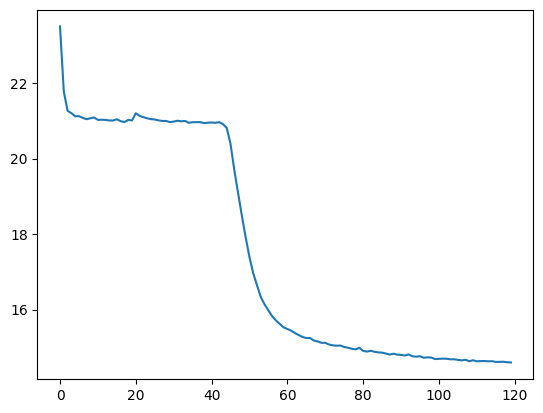

In [11]:
plt.figure()
plt.plot(avg_loss)

## Sampling from the model

In [12]:
def sample(net, num_samples, data, hist_length, pred_length):
    max_idx = data.shape[1] - (hist_length + pred_length)
    
    idx = np.random.randint(0, max_idx)
    hist_value = torch.Tensor(data[:, idx:idx+hist_length]).to(device)
    pred_value = torch.Tensor(data[:, idx+hist_length:idx+hist_length+pred_length]).to(device)
    
    # [batch, series, time steps]
    hist_value = hist_value[None, :, :]
    pred_value = pred_value[None, :, :]
    hist_time = torch.arange(0, hist_length, device=device)[None, :]
    pred_time = torch.arange(hist_length, hist_length + pred_length, device=device)[None, :]

    samples = net.sample(num_samples, hist_time, hist_value, pred_time)
    
    return samples, torch.cat([hist_value, pred_value], axis=2), torch.cat([hist_time, pred_time], axis=1)

In [13]:
samples, pred_value, timesteps = sample(net, 1000, data_test, 10, 10)

In [14]:
def plot_single_series(samples, target, timesteps, index):
    s_samples = samples[0, index, :, :].cpu().numpy()
    s_timesteps = timesteps[0, :].cpu().numpy()
    s_target = target[0, index, :].cpu().numpy()
    
    plt.figure()
    
    for zorder, quant, color, label in [
        [1, 0.05, (0.75,0.75,1), "5%-95%"],
        [2, 0.10, (0.25,0.25,1), "10%-90%"],
        [3, 0.25, (0,0,0.75), "25%-75%"],
    ]:
        plt.fill_between(
            s_timesteps,
            np.quantile(s_samples, quant, axis=1),
            np.quantile(s_samples, 1 - quant, axis=1),
            facecolor=color,
            interpolate=True,
            label=label,
            zorder=zorder,
        )
    
    plt.plot(
        s_timesteps,
        np.quantile(s_samples, 0.5, axis=1),
        color=(0.5,0.5,0.5),
        linewidth=3,
        label="50%",
        zorder=4,
    )
    
    plt.plot(s_timesteps, s_target, color=(0, 0, 0), linewidth=2, zorder=5, label="ground truth")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 2, 3, 4, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

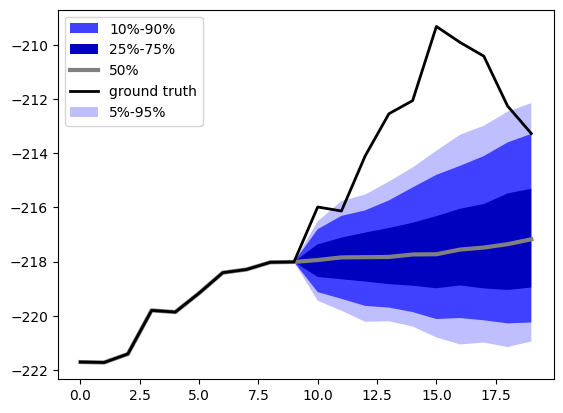

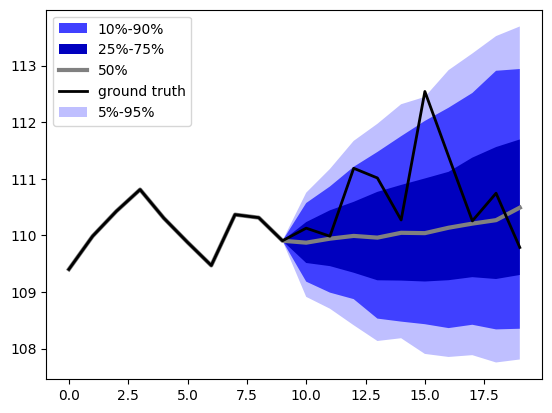

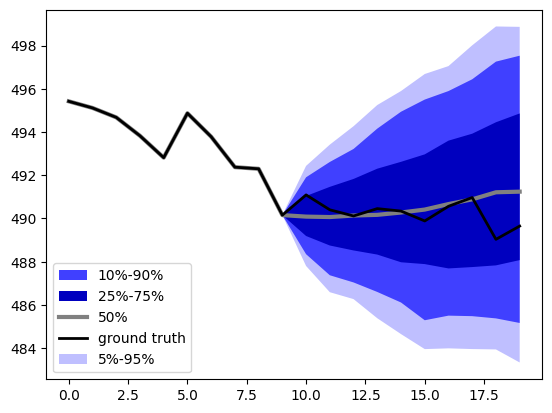

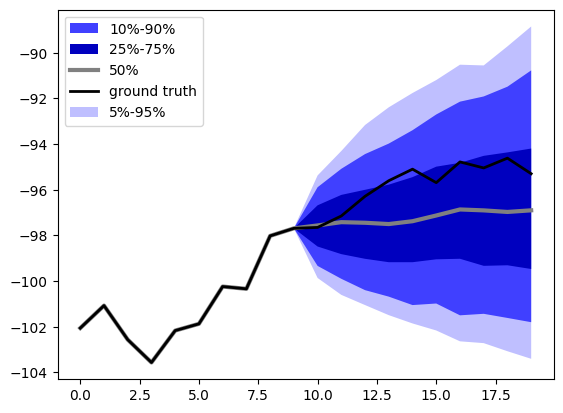

In [15]:
for i in range(4):
    plot_single_series(samples, pred_value, timesteps, i)

The variance of the random walk process is easy to compute: since each step adds a Normal(0,1) to the previous value, then the variance of the generating process after $n$ steps is equal to $n$.

The variance in the result is the consequence of the standardization procedure, which prevents the model from learning that the variance should only depends on the step number.

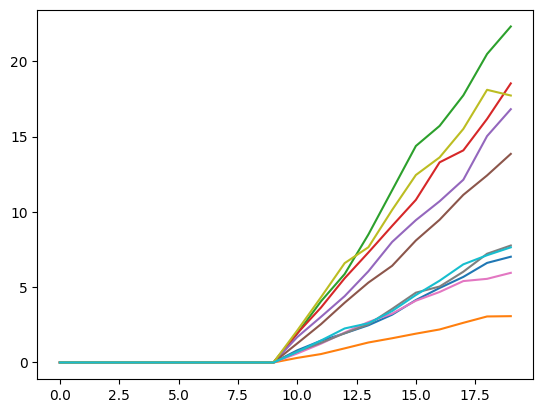

In [16]:
plt.figure()
plt.plot(samples[0, :, :, :].var(dim=2).cpu().transpose(0,1))
plt.show()

The correlations should increase as we go to later time steps, especially for close time steps.

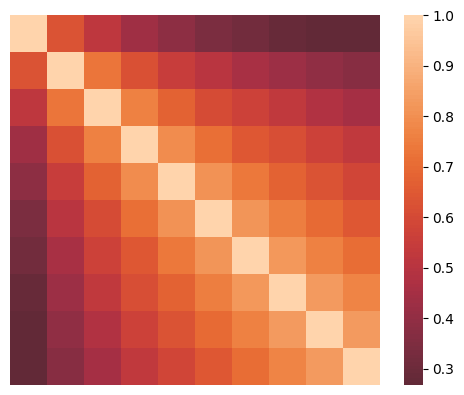

In [17]:
corrcoef = 0
for b in range(samples.shape[0]):
    for v in range(samples.shape[1]):
        spl = samples[b,v,10:,:].cpu().numpy()
        corrcoef = corrcoef + np.corrcoef(spl)
corrcoef /= (samples.shape[0] * samples.shape[1])

plt.figure()

svm = sns.heatmap(corrcoef, robust=True, center=0, xticklabels=False, yticklabels=False)
plt.gca().set_aspect('equal', 'box')
plt.show()